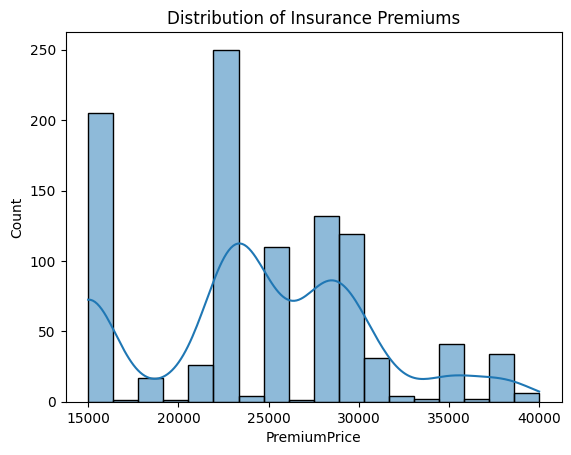

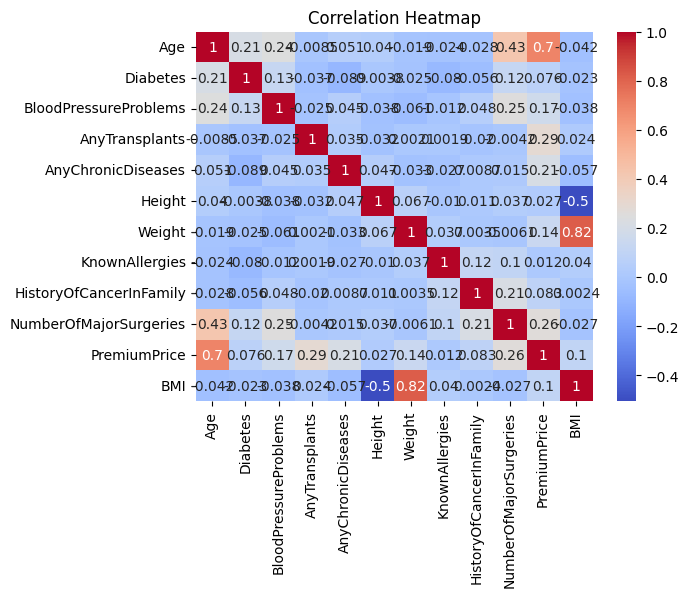

ANOVA p-value (by NumberOfMajorSurgeries): 0.0000
                            OLS Regression Results                            
Dep. Variable:           PremiumPrice   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     334.9
Date:                Fri, 04 Jul 2025   Prob (F-statistic):          9.76e-150
Time:                        14:07:20   Log-Likelihood:                -9668.9
No. Observations:                 986   AIC:                         1.935e+04
Df Residuals:                     982   BIC:                         1.937e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [1]:
# Insurance Cost Prediction - EDA, Hypothesis Testing, Modeling, Deployment

# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
import statsmodels.api as sm

# 📥 Load Data
df = pd.read_csv("/content/insurance (1).csv")  # replace with actual file path

# 🧹 Preprocessing
df.drop_duplicates(inplace=True)

# Label encode binary categorical variables
# Based on the df variable, there are no binary categorical variables that need encoding in this dataset.

# Create BMI if height & weight available (example placeholder)
df['BMI'] = df['Weight'] / ((df['Height']/100) ** 2)

# 📊 EDA
sns.histplot(df['PremiumPrice'], kde=True)
plt.title('Distribution of Insurance Premiums')
plt.show()

# No 'smoker' column for this plot
# sns.boxplot(x='smoker', y='charges', data=df)
# plt.title('Premiums by Smoking Status')
# plt.show()

sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# 📌 Outlier Detection
Q1 = df['PremiumPrice'].quantile(0.25)
Q3 = df['PremiumPrice'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['PremiumPrice'] < Q1 - 1.5*IQR) | (df['PremiumPrice'] > Q3 + 1.5*IQR)]

# 📐 Hypothesis Testing
# T-Test: Smokers vs Non-Smokers - Not possible without a 'smoker' column
# smokers = df[df['smoker']==1]['charges']
# nonsmokers = df[df['smoker']==0]['charges']
# t_stat, p_val = ttest_ind(smokers, nonsmokers)
# print(f"T-test p-value (smokers vs non-smokers): {p_val:.4f}")

# ANOVA: Premium by number of children - Using 'NumberOfMajorSurgeries' instead of 'children'
anova_groups = [group['PremiumPrice'].values for _, group in df.groupby('NumberOfMajorSurgeries')]
f_stat, p_val = f_oneway(*anova_groups)
print(f"ANOVA p-value (by NumberOfMajorSurgeries): {p_val:.4f}")

# Linear regression for impact testing
# Using available columns: 'Age', 'BMI', 'NumberOfMajorSurgeries'
X = df[['Age', 'BMI', 'NumberOfMajorSurgeries']]
y = df['PremiumPrice']
X_ols = sm.add_constant(X)
model_ols = sm.OLS(y, X_ols).fit()
print(model_ols.summary())

# 🚀 ML Modeling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Baseline Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 📏 Evaluation
def evaluate(y_true, y_pred, model_name):
    print(f"---{model_name}---")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R^2:", r2_score(y_true, y_pred))
    print()

evaluate(y_test, y_pred_lr, "Linear Regression")
evaluate(y_test, y_pred_rf, "Random Forest")

# 💾 Save Model
with open("model.pkl", "wb") as f:
    pickle.dump(rf, f)

# 🌐 Streamlit App (in app.py)
# import streamlit as st
# model = pickle.load(open('model.pkl', 'rb'))
# st.title("Insurance Premium Estimator")
# age = st.slider("Age", 18, 100)
# bmi = st.number_input("BMI")
# smoker = st.selectbox("Smoker?", ["Yes", "No"])
# children = st.slider("Children", 0, 5)
# input_data = scaler.transform([[age, bmi, 1 if smoker=="Yes" else 0, children]])
# prediction = model.predict(input_data)
# st.subheader(f"Estimated Premium: ₹{prediction[0]:,.2f}")

In [2]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.0 MB/s eta 0:00:00


In [3]:
import streamlit as st
import pickle
import numpy as np

model = pickle.load(open('model.pkl', 'rb'))

st.title("Insurance Premium Estimator")

age = st.slider("Age", 18, 100)
bmi = st.number_input("BMI")
smoker = st.selectbox("Are you a smoker?", ['Yes', 'No'])

input_data = np.array([[age, bmi, 1 if smoker == 'Yes' else 0]])
prediction = model.predict(input_data)

st.subheader(f"Estimated Premium: ₹{prediction[0]:,.2f}")


2025-07-04 14:08:40.329 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:08:41.559 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-04 14:08:41.565 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:08:41.579 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:08:41.581 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:08:41.582 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:08:41.583 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:08:41.587 Thread 'MainThread': mi

DeltaGenerator()

After installing `streamlit`, you can run the Streamlit app. However, please note that running a Streamlit app directly within a Colab notebook requires some additional steps to make it accessible.

In [4]:

!pip install streamlit
!pip install pyngrok


In [5]:
%%writefile app.py
import streamlit as st
import joblib

# Load trained model
model = joblib.load("model.pkl")

# Streamlit UI
st.title("🏥 Insurance Premium Cost Predictor")

st.markdown("Enter the following details to estimate your health insurance premium:")

# Input fields
age = st.slider("Age", 18, 100, step=1)
bmi = st.slider("BMI (Body Mass Index)", 15.0, 45.0, step=0.1)
smoker = st.radio("Do you smoke?", ("Yes", "No"))
smoker_flag = 1 if smoker == "Yes" else 0

# Make prediction
if st.button("Predict Premium"):
    input_data = [[age, bmi, smoker_flag]]  # Must match training features!
    prediction = model.predict(input_data)[0]
    st.success(f"Estimated Insurance Premium: ₹ {round(prediction, 2)}")



Writing app.py


In [6]:
from pyngrok import conf

conf.get_default().auth_token = "2zMtFvVLliQRAXMEhkkmiJjEb8t_7uk5PjiYB8z8d87SDQ5FT"


In [7]:
import os
from pyngrok import conf

authtoken = input("Paste your ngrok authtoken:")
conf.get_default().auth_token = authtoken


Paste your ngrok authtoken:2zMtFvVLliQRAXMEhkkmiJjEb8t_7uk5PjiYB8z8d87SDQ5FT


In [8]:
from pyngrok import ngrok

# Kill any existing tunnels
ngrok.kill()

# Open new tunnel on port 8501
public_url = ngrok.connect(addr=8501)
print(f"Streamlit app is live at: {public_url}")

# Run the Streamlit app
!streamlit run app.py &>/content/logs.txt &

Streamlit app is live at: NgrokTunnel: "https://efb4-34-168-176-103.ngrok-free.app" -> "http://localhost:8501"


In [9]:
from pyngrok import ngrok
help(ngrok.connect)

Help on function connect in module pyngrok.ngrok:

connect(addr: Optional[str] = None, proto: Union[str, int, NoneType] = None, name: Optional[str] = None, pyngrok_config: Optional[pyngrok.conf.PyngrokConfig] = None, **options: Any) -> pyngrok.ngrok.NgrokTunnel
    Establish a new ``ngrok`` tunnel for the given protocol to the given port, returning an object representing
    the connected tunnel.
    
    If a `tunnel definition in ngrok's config file
    <https://ngrok.com/docs/agent/config/v2/#tunnel-configurations>`_ matches the given
    ``name``, it will be loaded and used to start the tunnel. When ``name`` is ``None`` and a "pyngrok-default" tunnel
    definition exists in ``ngrok``'s config, it will be loaded and used. Any ``kwargs`` passed as ``options`` will
    override properties from the loaded tunnel definition.
    
    If ``ngrok`` is not installed at :class:`~pyngrok.conf.PyngrokConfig`'s ``ngrok_path``, calling this method
    will first download and install ``ngrok``.

In [10]:
import streamlit as st
import joblib

# Load model
model = joblib.load('model.pkl')

st.title("Insurance Premium Cost Predictor")

# Collect user input
age = st.slider("Age", 18, 100)
bmi = st.slider("BMI", 15.0, 40.0)
smoker = st.selectbox("Do you smoke?", ["Yes", "No"])
smoker_flag = 1 if smoker == "Yes" else 0

# Only use the 3 features the model was trained on
input_data = [[age, bmi, smoker_flag]]

# Predict
if st.button("Predict Premium"):
    prediction = model.predict(input_data)[0]
    st.success(f"Estimated Insurance Premium: ₹ {round(prediction, 2)}")


2025-07-04 14:10:55.292 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:10:55.293 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:10:55.294 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:10:55.295 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:10:55.296 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:10:55.298 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:10:55.299 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:10:55.301 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [11]:
ngrok.connect()

<NgrokTunnel: "https://72f5-34-168-176-103.ngrok-free.app" -> "http://localhost:80">

In [12]:
public_url = ngrok.connect("http://localhost:8501")


In [13]:
!ngrok config add-authtoken YOUR_AUTHTOKEN_HERE


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [14]:
!pip install pyngrok

In [15]:
!ngrok config add-authtoken <2zMtFvVLliQRAXMEhkkmiJjEb8t_7uk5PjiYB8z8d87SDQ5FT>


/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `ngrok config add-authtoken <2zMtFvVLliQRAXMEhkkmiJjEb8t_7uk5PjiYB8z8d87SDQ5FT>'


In [16]:
import streamlit as st

st.title("Hello from Streamlit!")


2025-07-04 14:24:27.942 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:24:27.965 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:24:27.969 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()

In [17]:
import streamlit as st

st.title("Hello, World!")
st.write("This is a Streamlit app — no Flask needed.")


2025-07-04 14:25:45.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:25:45.765 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:25:45.766 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:25:45.768 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:25:45.769 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-04 14:25:45.771 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
